In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Project-1

# - Goal: ImageDataGenerator와 TL을 이용해서 오버피팅이 최소가 될 수 있도록 90% 이상의 정확도 달성
# - 만약 오버피팅이 심하고 90% 이상의 성능이 나오지 않는다면, 문제점과 해결 방안을 찾아본다.


In [ ]:
!pip install opencv-python

In [ ]:
### 경로 설정

# colab
ROOT_DIR='/content'
# loocal
#ROOT_DIR='content'
DATA_ROOT_DIR=os.path.join(ROOT_DIR, 'data2')
TRAIN_DATA_ROOT_DIR= os.path.join(ROOT_DIR, 'Training')
TEST_DATA_ROOT_DIR= os.path.join(ROOT_DIR, 'Testing')

# if not os.path.exists(DATA_ROOT_DIR):
#     os.mkdir(DATA_ROOT_DIR)
if not os.path.exists(TRAIN_DATA_ROOT_DIR):
    os.mkdir(TRAIN_DATA_ROOT_DIR)
if not os.path.exists(TEST_DATA_ROOT_DIR):
    os.mkdir(TEST_DATA_ROOT_DIR)

In [ ]:
import os

current_directory = os.getcwd()
print(current_directory)

/content


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

shutil.copy(os.path.join('/content/drive/MyDrive/', '이미지재검수합본_4차_with_pizza_final.zip'), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

IMG_WIDTH= 224
IMG_HEIGHT= 224

Mounted at /content/drive


In [ ]:
import os
os.environ['PYTHONIOENCODING'] = 'cp949'

In [ ]:
import zipfile

!mkdir data2
%cd /content/data2

input_file = '../이미지재검수합본_4차_with_pizza_final.zip'
zip_encoding = 'cp949'  # Changed encoding scheme to 'cp949'

with zipfile.ZipFile(input_file, 'r') as z:
    for file_info in z.infolist():
        file_info.filename = file_info.filename.encode('cp437').decode(zip_encoding)  # cp437 is commonly used in ZIP
        z.extract(file_info, '.', pwd=None)

print("압축 해제가 완료되었습니다.")

%cd /content


/content/data2
압축 해제가 완료되었습니다.
/content


In [ ]:
######## data2 파일 밑에 있는 data2 (empty) 파일 (만약 생기면. 생길때도 있고 생기지 않을 때도 있음) 수동으로 지움

In [ ]:
label_name_list= os.listdir(DATA_ROOT_DIR)
train_label_name_list= os.listdir(TRAIN_DATA_ROOT_DIR)
print(label_name_list)

['부대찌개', '비빔국수', '탕수육', '떡국', '해물찜', '삼계탕', '생선조림', '김밥', '라면', '오징어(낙지)볶음', '쫄면', '갈비찜', '김치찌개', '된장찌개', '꽃게탕', '짬뽕', '비빔밥', '설렁탕', '카레', '콩국수', '김치볶음밥', '순대볶음', '함박스테이크', '오므라이스', '순두부찌개', '물냉면', '갈비탕', '찜닭', '오일스파게티', '닭볶음탕', '수육', '메밀소바', '피자', '닭발', '뼈해장국', '육개장', '볶음우동', '잔치국수', '후라이드치킨', '오리고기', '유부초밥', '우동', '족발', '크림스파게티', '칼국수', '생선구이', '초밥', '짜장면', '양념치킨', '스테이크', '삼겹살구이', '육회', '불고기', '수제비', '떡볶이', '계란볶음밥', '토마토스파게티', '돈까스', '제육볶음']


In [ ]:
len(label_name_list)

59

In [ ]:
import cv2
import os
import shutil




for label_name in label_name_list:
    data_path = os.path.join(DATA_ROOT_DIR, label_name)
    data_path = os.path.join(data_path, "image")

    folder_path = data_path

    # Transformation options
    angles = [45, 90, 135]
    flip_options = [True, False]  # Include horizontal flip
    zoom_factors = [0.8]  # Include zoomed-in images

    # Get image file list
    image_files = os.listdir(folder_path)

    # Apply transformations and save images
    for file_name in image_files:
        # File path
        file_path = os.path.join(folder_path, file_name)

        # Load image
        image = cv2.imread(file_path)

        # Apply transformations
        for angle in angles:
            # Rotate image
            height, width = image.shape[:2]
            center = (width / 2, height / 2)
            matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            warped_image = cv2.warpAffine(image, matrix, (width, height))

            # Save rotated image
            new_file_name = f'{angle}degrees_{file_name}'
            new_file_path = os.path.join(folder_path, new_file_name)
            cv2.imwrite(new_file_path, warped_image)
            print(f'{file_name} -> {new_file_name}')

            # Horizontal flip
            for flip_option in flip_options:
                flipped_image = cv2.flip(warped_image, 1) if flip_option else warped_image

                # Save flipped image
                flip_suffix = 'flipped' if flip_option else 'original'
                new_file_name = f'{angle}degrees_{flip_suffix}_{file_name}'
                new_file_path = os.path.join(folder_path, new_file_name)
                cv2.imwrite(new_file_path, flipped_image)
                print(f'{file_name} -> {new_file_name}')

                # Zoomed-in images
                for zoom_factor in zoom_factors:
                    zoomed_image = cv2.resize(flipped_image, None, fx=zoom_factor, fy=zoom_factor)

                    # Save zoomed-in image
                    zoom_suffix = f'zoom{zoom_factor}' if zoom_factor != 1.0 else 'original'
                    new_file_name = f'{angle}degrees_{flip_suffix}{zoom_suffix}{file_name}'
                    new_file_path = os.path.join(folder_path, new_file_name)
                    cv2.imwrite(new_file_path, zoomed_image)
                    print(f'{file_name} -> {new_file_name}')

    # Move images to the train folder
    data_file_list = os.listdir(data_path)
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    os.mkdir(train_path)
    move_num = 0
    for data_file in data_file_list:
        shutil.copy(os.path.join(data_path, data_file), os.path.join(train_path, data_file))
        move_num += 1

    print(f'{move_num} image(s) moved into {label_name}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
205.png -> 135degrees_flipped_205.png
205.png -> 135degrees_flippedzoom0.8205.png
205.png -> 135degrees_original_205.png
205.png -> 135degrees_originalzoom0.8205.png
305.png -> 45degrees_305.png
305.png -> 45degrees_flipped_305.png
305.png -> 45degrees_flippedzoom0.8305.png
305.png -> 45degrees_original_305.png
305.png -> 45degrees_originalzoom0.8305.png
305.png -> 90degrees_305.png
305.png -> 90degrees_flipped_305.png
305.png -> 90degrees_flippedzoom0.8305.png
305.png -> 90degrees_original_305.png
305.png -> 90degrees_originalzoom0.8305.png
305.png -> 135degrees_305.png
305.png -> 135degrees_flipped_305.png
305.png -> 135degrees_flippedzoom0.8305.png
305.png -> 135degrees_original_305.png
305.png -> 135degrees_originalzoom0.8305.png
356.png -> 45degrees_356.png
356.png -> 45degrees_flipped_356.png
356.png -> 45degrees_flippedzoom0.8356.png
356.png -> 45degrees_original_356.png
356.png -> 45degrees_originalzoom0.8356.png
356.png -> 90degrees_356.png


In [ ]:
train_data_gen= ImageDataGenerator(rescale= 1./255, validation_split=0.2)
# test_data_gen= ImageDataGenerator(rescale= 1./255)

train_generator= train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32,
                                                color_mode='rgb',
                                                shuffle= True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='sparse',
                                                subset='training')

val_generator= train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32,
                                                color_mode='rgb',
                                                shuffle= True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='sparse',
                                                subset='validation')

# test_generator= test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
#                                               batch_size=32,
#                                               color_mode='rgb',
#                                               shuffle= True,
#                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                               class_mode='sparse')

print(train_generator.class_indices)

Found 212389 images belonging to 59 classes.
Found 53067 images belonging to 59 classes.
{'갈비찜': 0, '갈비탕': 1, '계란볶음밥': 2, '김밥': 3, '김치볶음밥': 4, '김치찌개': 5, '꽃게탕': 6, '닭발': 7, '닭볶음탕': 8, '돈까스': 9, '된장찌개': 10, '떡국': 11, '떡볶이': 12, '라면': 13, '메밀소바': 14, '물냉면': 15, '볶음우동': 16, '부대찌개': 17, '불고기': 18, '비빔국수': 19, '비빔밥': 20, '뼈해장국': 21, '삼겹살구이': 22, '삼계탕': 23, '생선구이': 24, '생선조림': 25, '설렁탕': 26, '수육': 27, '수제비': 28, '순대볶음': 29, '순두부찌개': 30, '스테이크': 31, '양념치킨': 32, '오리고기': 33, '오므라이스': 34, '오일스파게티': 35, '오징어(낙지)볶음': 36, '우동': 37, '유부초밥': 38, '육개장': 39, '육회': 40, '잔치국수': 41, '제육볶음': 42, '족발': 43, '짜장면': 44, '짬뽕': 45, '쫄면': 46, '찜닭': 47, '초밥': 48, '카레': 49, '칼국수': 50, '콩국수': 51, '크림스파게티': 52, '탕수육': 53, '토마토스파게티': 54, '피자': 55, '함박스테이크': 56, '해물찜': 57, '후라이드치킨': 58}


In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
### move 완료된 Training 전체 데이터 갯수 확인

train_label_name_list= os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['부대찌개', '비빔국수', '탕수육', '떡국', '해물찜', '삼계탕', '생선조림', '김밥', '라면', '오징어(낙지)볶음', '쫄면', '갈비찜', '김치찌개', '된장찌개', '꽃게탕', '짬뽕', '비빔밥', '설렁탕', '카레', '콩국수', '김치볶음밥', '순대볶음', '함박스테이크', '오므라이스', '순두부찌개', '물냉면', '갈비탕', '찜닭', '오일스파게티', '닭볶음탕', '수육', '메밀소바', '피자', '닭발', '뼈해장국', '육개장', '볶음우동', '잔치국수', '후라이드치킨', '오리고기', '유부초밥', '우동', '족발', '크림스파게티', '칼국수', '생선구이', '초밥', '짜장면', '양념치킨', '스테이크', '삼겹살구이', '육회', '불고기', '수제비', '떡볶이', '계란볶음밥', '토마토스파게티', '돈까스', '제육볶음']
train label:  부대찌개 => 3488
train label:  비빔국수 => 3072
train label:  탕수육 => 4320
train label:  떡국 => 5456
train label:  해물찜 => 5168
train label:  삼계탕 => 2528
train label:  생선조림 => 9904
train label:  김밥 => 12304
train label:  라면 => 1520
train label:  오징어(낙지)볶음 => 9024
train label:  쫄면 => 1680
train label:  갈비찜 => 10448
train label:  김치찌개 => 2288
train label:  된장찌개 => 2960
train label:  꽃게탕 => 3584
train label:  짬뽕 => 4416
train label:  비빔밥 => 8928
train label:  설렁탕 => 864
train label:  카레 => 6960
train label:  콩국수 => 4144
train label:  김치볶음밥 => 68

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_10 (Dropout)        (None, 1024)             

[0.16712743043899536, 0.9536811709403992]

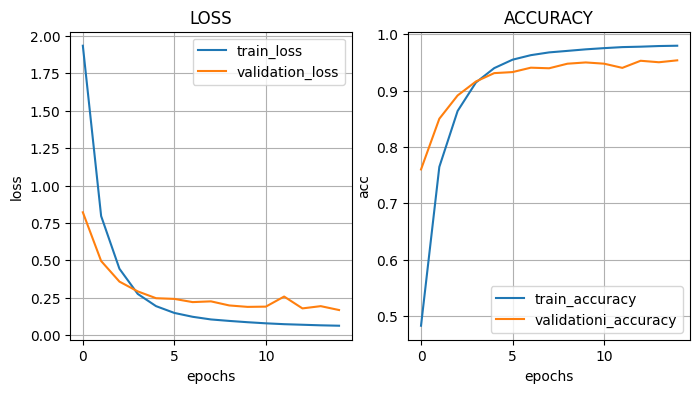

In [ ]:
pre_trained_model= MobileNet(weights='imagenet', include_top=False,
                            input_shape= (IMG_WIDTH, IMG_HEIGHT, 3))
# pre_trained_model.summary()

model= Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(59, activation='softmax'))

model.summary()


# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(5e-5), metrics=['acc']) #colab: lr=2e-5

# # Define early stopping criteria
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


start_time= datetime.now()

tf_chk = tf.keras.callbacks.ModelCheckpoint('food_model_5.h5', monitor="val_loss",save_best_only=True)
result = model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=[tf_chk])
end_time= datetime.now()
print('걸린시간: ', end_time - start_time)

#### 그래프
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

model.evaluate(val_generator)

In [ ]:
model.save('food_model_5.h5')

In [ ]:
import os

# Check the files in the current working directory
files = os.listdir()
print(files)


['.config', 'data2', 'Training', '이미지재검수합본_4차_with_pizza_final.zip', 'drive', 'food_model.h5', 'Testing', 'sample_data']


In [ ]:
import zipfile

# Create a new zip file
with zipfile.ZipFile('food_model_5.zip', 'w') as zipf:
    # Add the HDF5 model file to the zip
    zipf.write('food_model_5.h5')

    # Add any additional files related to your model, if necessary
    # zipf.write('other_file.txt')
    # zipf.write('another_file.pickle')


In [ ]:
np.argmax(model.predict(test_image.reshape(-1, 224,224, 3)))

1/1 [==============================] - 0s 21ms/step


44

In [ ]:
print(train_generator.class_indices)

{'갈비찜': 0, '갈비탕': 1, '계란볶음밥': 2, '김밥': 3, '김치볶음밥': 4, '김치찌개': 5, '꽃게탕': 6, '닭발': 7, '닭볶음탕': 8, '돈까스': 9, '된장찌개': 10, '떡국': 11, '떡볶이': 12, '라면': 13, '메밀소바': 14, '물냉면': 15, '볶음우동': 16, '부대찌개': 17, '불고기': 18, '비빔국수': 19, '비빔밥': 20, '뼈해장국': 21, '삼겹살구이': 22, '삼계탕': 23, '생선구이': 24, '생선조림': 25, '설렁탕': 26, '수육': 27, '수제비': 28, '순대볶음': 29, '순두부찌개': 30, '스테이크': 31, '양념치킨': 32, '오리고기': 33, '오므라이스': 34, '오일스파게티': 35, '오징어(낙지)볶음': 36, '우동': 37, '유부초밥': 38, '육개장': 39, '육회': 40, '잔치국수': 41, '제육볶음': 42, '족발': 43, '짜장면': 44, '짬뽕': 45, '쫄면': 46, '찜닭': 47, '초밥': 48, '카레': 49, '칼국수': 50, '콩국수': 51, '크림스파게티': 52, '탕수육': 53, '토마토스파게티': 54, '피자': 55, '함박스테이크': 56, '해물찜': 57, '후라이드치킨': 58}


1/1 [==============================] - 0s 30ms/step
{'갈비찜': 0, '갈비탕': 1, '계란볶음밥': 2, '김밥': 3, '김치볶음밥': 4, '김치찌개': 5, '꽃게탕': 6, '닭발': 7, '닭볶음탕': 8, '돈까스': 9, '된장찌개': 10, '떡국': 11, '떡볶이': 12, '라면': 13, '메밀소바': 14, '물냉면': 15, '볶음우동': 16, '부대찌개': 17, '불고기': 18, '비빔국수': 19, '비빔밥': 20, '뼈해장국': 21, '삼겹살구이': 22, '삼계탕': 23, '생선구이': 24, '생선조림': 25, '설렁탕': 26, '수육': 27, '수제비': 28, '순대볶음': 29, '순두부찌개': 30, '스테이크': 31, '양념치킨': 32, '오리고기': 33, '오므라이스': 34, '오일스파게티': 35, '오징어(낙지)볶음': 36, '우동': 37, '유부초밥': 38, '육개장': 39, '육회': 40, '잔치국수': 41, '제육볶음': 42, '족발': 43, '짜장면': 44, '짬뽕': 45, '쫄면': 46, '찜닭': 47, '초밥': 48, '카레': 49, '칼국수': 50, '콩국수': 51, '크림스파게티': 52, '탕수육': 53, '토마토스파게티': 54, '피자': 55, '함박스테이크': 56, '해물찜': 57, '후라이드치킨': 58}


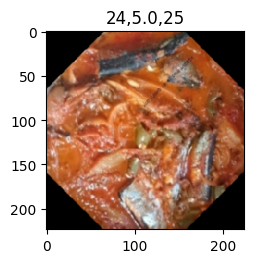

In [ ]:
X, y = val_generator.next()

ret_val = model.predict(X)

pred_val = np.argmax(ret_val, axis=1)
pred_comp_val = np.equal(pred_val, y)

index_label_pred_list = [[idx, y[idx], pred_val[idx]] for idx, result in enumerate(pred_comp_val) if result==False]

false_data_index = np.random.randint(len(index_label_pred_list))

plt.figure(figsize=(24, 12))

for i, j in enumerate(index_label_pred_list):
  plt.subplot(4, 8, i+1)

  mnist_index = index_label_pred_list[i][0]
  label = index_label_pred_list[i][1]
  pred = index_label_pred_list[i][2]

  img = X[mnist_index]

  title = str(mnist_index) + "," + str(label) + "," + str(pred)
  plt.title(title)
  plt.imshow(img)
print(val_generator.class_indices)